In [1]:
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import pandas as pd

# calculate accuracy measures and confusion matrix
from sklearn import metrics

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....

In [6]:
credit_df = pd.read_csv("credit.csv")

In [7]:
credit_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
months_loan_duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
percent_of_income,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
years_at_residence,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_loans_count,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [8]:
credit_df.head(10)  #let us look at the raw data. As is evident, there are lot of missing values

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
5,unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no
6,unknown,24,good,furniture/appliances,2835,500 - 1000 DM,> 7 years,3,4,53,none,own,1,skilled,1,no,no
7,1 - 200 DM,36,good,car,6948,< 100 DM,1 - 4 years,2,2,35,none,rent,1,management,1,yes,no
8,unknown,12,good,furniture/appliances,3059,> 1000 DM,4 - 7 years,2,4,61,none,own,1,unskilled,1,no,no
9,1 - 200 DM,30,critical,car,5234,< 100 DM,unemployed,4,2,28,none,own,2,management,1,no,yes


In [9]:
credit_df.shape

(1000, 17)

In [10]:
credit_df.describe(include=[np.number])


,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [11]:
credit_df.info()  # many columns are of type object i.e. strings. These need to be converted to ordinal type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
checking_balance        1000 non-null object
months_loan_duration    1000 non-null int64
credit_history          1000 non-null object
purpose                 1000 non-null object
amount                  1000 non-null int64
savings_balance         1000 non-null object
employment_duration     1000 non-null object
percent_of_income       1000 non-null int64
years_at_residence      1000 non-null int64
age                     1000 non-null int64
other_credit            1000 non-null object
housing                 1000 non-null object
existing_loans_count    1000 non-null int64
job                     1000 non-null object
dependents              1000 non-null int64
phone                   1000 non-null object
default                 1000 non-null object
dtypes: int64(7), object(10)
memory usage: 132.9+ KB


In [12]:
# Decision tree in Python can take only numerical / categorical colums. It cannot take string / obeject types. 
# The following code loops through each column and checks if the column type is object then converts those columns
# into categorical with each distinct value becoming a category or code.

for feature in credit_df.columns: # Loop through all columns in the dataframe
    if credit_df[feature].dtype == 'object': # Only apply for columns with categorical strings
        credit_df[feature] = pd.Categorical(credit_df[feature]).codes # Replace strings with an integer

In [13]:
credit_df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,1,6,0,4,1169,4,3,4,4,67,1,1,2,1,1,1,0
1,0,48,1,4,5951,2,0,2,2,22,1,1,1,1,1,0,1
2,3,12,0,3,2096,2,1,2,3,49,1,1,1,3,2,0,0
3,1,42,1,4,7882,2,1,2,4,45,1,0,1,1,2,0,0
4,1,24,3,1,4870,2,0,3,4,53,1,0,2,1,2,0,1


In [14]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
checking_balance        1000 non-null int8
months_loan_duration    1000 non-null int64
credit_history          1000 non-null int8
purpose                 1000 non-null int8
amount                  1000 non-null int64
savings_balance         1000 non-null int8
employment_duration     1000 non-null int8
percent_of_income       1000 non-null int64
years_at_residence      1000 non-null int64
age                     1000 non-null int64
other_credit            1000 non-null int8
housing                 1000 non-null int8
existing_loans_count    1000 non-null int64
job                     1000 non-null int8
dependents              1000 non-null int64
phone                   1000 non-null int8
default                 1000 non-null int8
dtypes: int64(7), int8(10)
memory usage: 64.5 KB


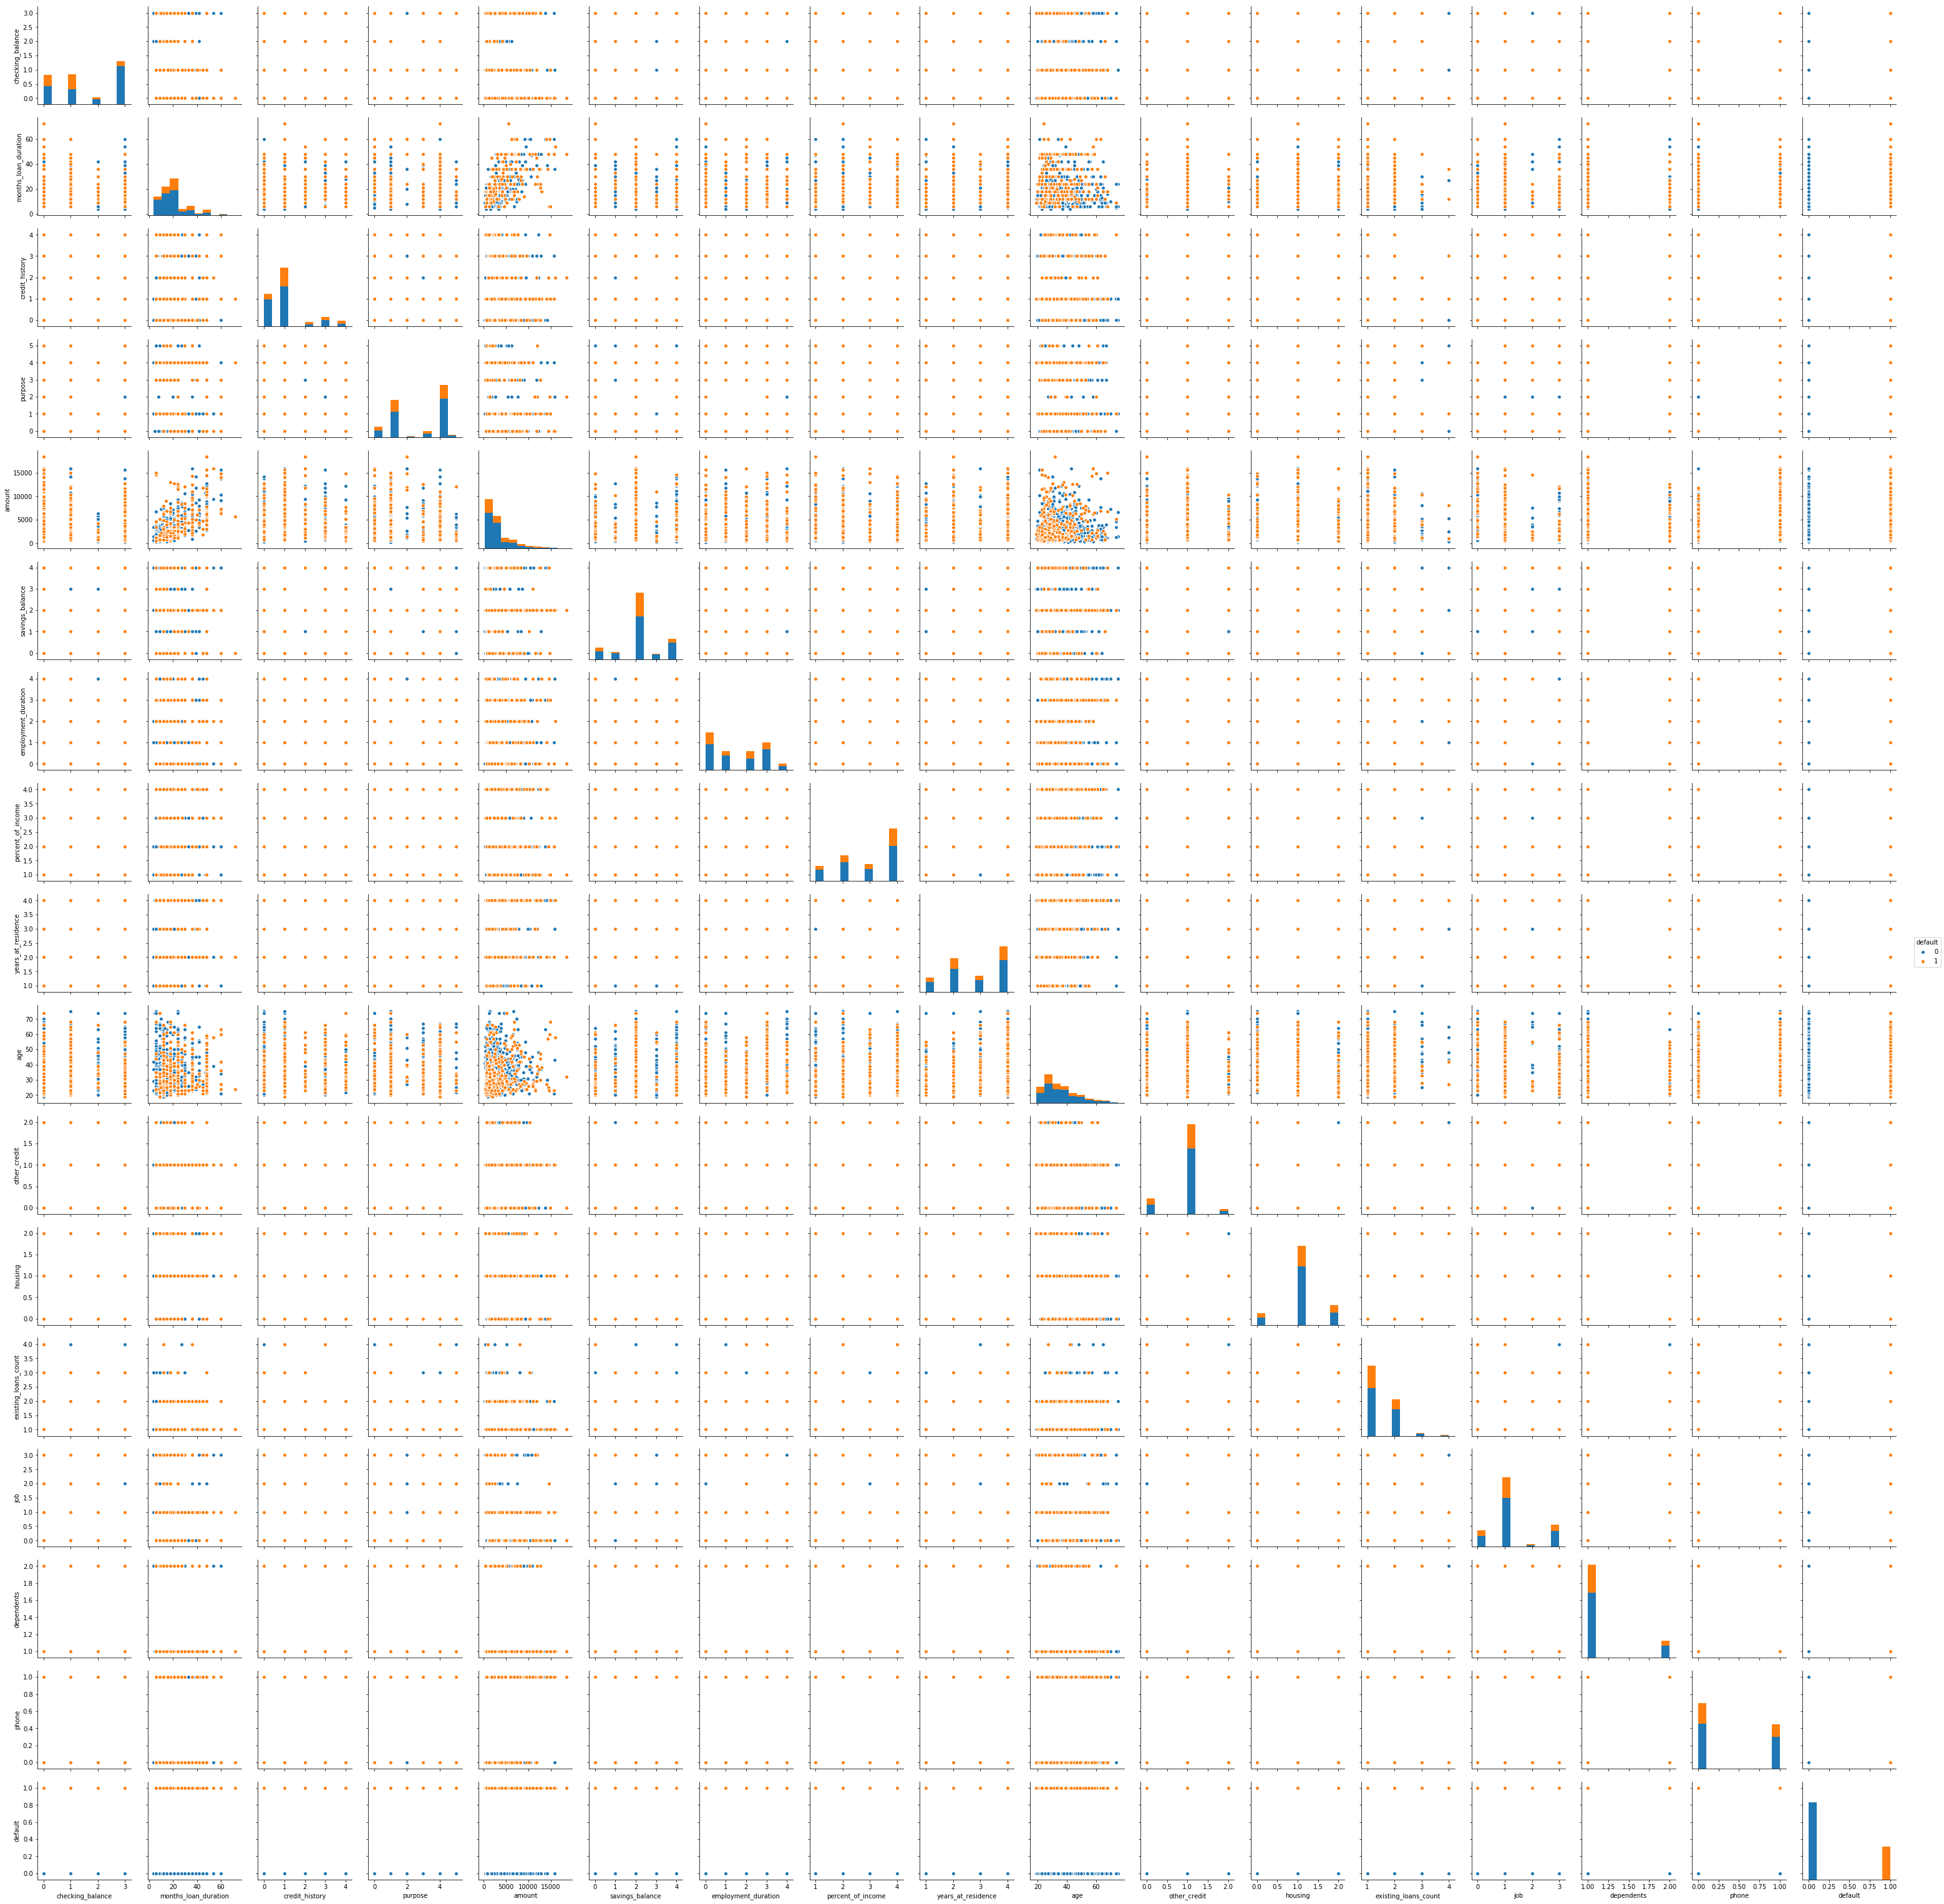

In [15]:
# Pairplot using sns
import seaborn as sns
sns.pairplot(credit_df, hue = "default")

In [16]:
col_labels = [ 'checking_balance', 'months_loan_duration' ,'credit_history' , 'purpose, amount', 'savings_balance' , 'employment_duration'
, 'percent_of_income', 'years_at_residence', 'age', 'other_credit', 'housing', 'existing_loans_count', 'job', 'dependents', 'phone', 'default']

In [17]:
train_char_label = ['No', 'Yes']

In [18]:
# capture the target column ("default") into separate vectors for training set and test set

X = credit_df.drop("default" , axis=1)

y = credit_df.pop("default")




In [19]:
# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.30, random_state=1)


In [20]:
# invoking the decision tree classifier function. Using 'entropy' method of finding the split columns. Other option 
# could be gini index.  Restricting the depth of the tree to 5 (no particular reason for selecting this)

#dt_model = DecisionTreeClassifier(criterion = 'entropy' , max_depth = 5, random_state = 100)
                                  
dt_model = DecisionTreeClassifier(criterion = 'entropy' )

In [21]:
dt_model.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [22]:
from sklearn import tree
Credit_Tree = open('Credit_Tree.dot','w')
dot_data = tree.export_graphviz(dt_model, out_file=Credit_Tree, feature_names = list(X_train), class_names = list(train_char_label))
Credit_Tree.close()

print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                           Imp
checking_balance      0.122194
months_loan_duration  0.076050
credit_history        0.071219
purpose               0.060128
amount                0.179268
savings_balance       0.075787
employment_duration   0.045108
percent_of_income     0.027475
years_at_residence    0.037645
age                   0.147875
other_credit          0.045786
housing               0.025136
existing_loans_count  0.024948
job                   0.023043
dependents            0.023902
phone                 0.014436


In [23]:
# You can also copy the script in the .dot file and paste it at http://webgraphviz.com/ to get tree view 
#or create a .png as below

#system("dot -Tpng D:\credit_tree.dot -o D:/credit_tree.png")
#Image("d:\credit_tree.png")

In [24]:
y_predict = dt_model.predict(X_test)

In [25]:
print(dt_model.score(X_train , Y_train))
print(dt_model.score(X_test , Y_test))

1.0
0.66


In [26]:
import matplotlib.pyplot as matplot
import itertools
def plot_confusion_matrix(Y_test,Y_predict, target_names,title='Confusion matrix',cmap=None,normalize=True):
    cm = metrics.confusion_matrix(Y_test, Y_predict)
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = matplot.get_cmap('Blues')

    matplot.figure(figsize=(8, 6))
    matplot.imshow(cm, interpolation='nearest', cmap=cmap)
    matplot.title(title)
    matplot.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        matplot.xticks(tick_marks, target_names, rotation=45)
        matplot.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            matplot.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            matplot.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    matplot.tight_layout()
    matplot.ylabel('True label')
    matplot.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    matplot.show()
    print(metrics.classification_report(Y_test, Y_predict))
    model_performance = [metrics.accuracy_score(Y_test, Y_predict),metrics.recall_score(Y_test, Y_predict),
                         metrics.precision_score(Y_test, Y_predict),metrics.f1_score(Y_test, Y_predict) ]
    accuracy_report = pd.DataFrame(model_performance, columns=['Model_Performance'], 
                                   index=['Accuracy','Recall','Precision','f1_Score'])
    return accuracy_report

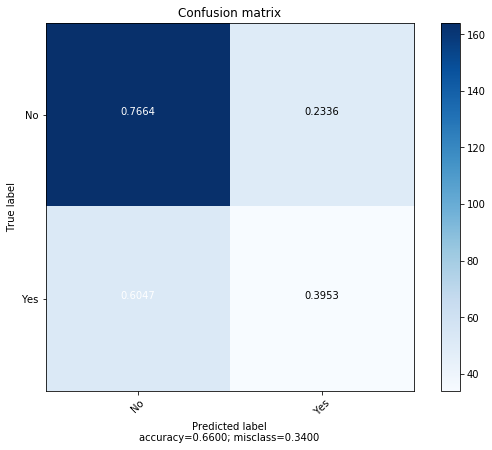

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       214
           1       0.40      0.40      0.40        86

    accuracy                           0.66       300
   macro avg       0.58      0.58      0.58       300
weighted avg       0.66      0.66      0.66       300



,Model_Performance
Accuracy,0.660000
Recall,0.395349
Precision,0.404762
f1_Score,0.400000


In [27]:
plot_confusion_matrix(Y_test,y_predict, target_names=train_char_label,title='Confusion matrix',cmap=None,normalize=True)

In [28]:
# Look at the class level metric for the defaulter class. It is poor. 

In [29]:
DT_Predictions = dt_model.predict(X_test)
DT_Predictions

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], d

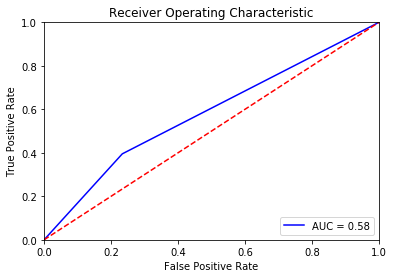

In [30]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = dt_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#                                      Regularising the Decision Tree

In [31]:
reg_dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)
reg_dt_model.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [32]:
Credit_Tree_Reg = open('Credit_Tree_Reg.dot','w')
dot_data = tree.export_graphviz(reg_dt_model, out_file=Credit_Tree_Reg, feature_names = list(X_train), class_names = list(train_char_label))
Credit_Tree.close()

print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                           Imp
checking_balance      0.122194
months_loan_duration  0.076050
credit_history        0.071219
purpose               0.060128
amount                0.179268
savings_balance       0.075787
employment_duration   0.045108
percent_of_income     0.027475
years_at_residence    0.037645
age                   0.147875
other_credit          0.045786
housing               0.025136
existing_loans_count  0.024948
job                   0.023043
dependents            0.023902
phone                 0.014436


In [33]:
# You can also copy the script in the .dot file and paste it at http://webgraphviz.com/ to get tree view
# or create a .png as below
#system("dot -Tpng D:\credit_tree_regularized.dot -o D:/credit_tree_regularized.png")
#Image("d:\credit_tree_regularized.png")

In [34]:
y_predict = reg_dt_model.predict(X_test)

In [35]:
reg_dt_model.score(X_test , Y_test)

0.71

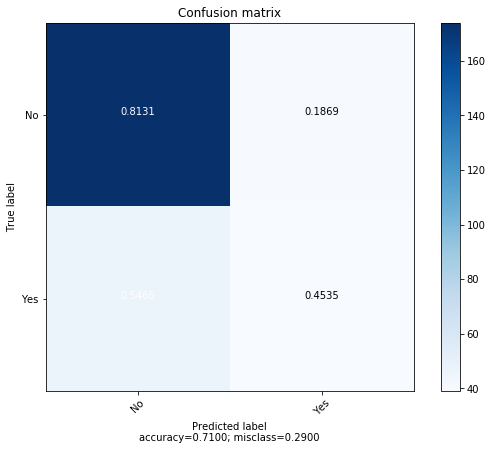

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       214
           1       0.49      0.45      0.47        86

    accuracy                           0.71       300
   macro avg       0.64      0.63      0.64       300
weighted avg       0.70      0.71      0.71       300



,Model_Performance
Accuracy,0.710000
Recall,0.453488
Precision,0.493671
f1_Score,0.472727


In [36]:
plot_confusion_matrix(Y_test,y_predict, target_names=train_char_label,title='Confusion matrix',cmap=None,normalize=True)

In [37]:
DT_Predictions = reg_dt_model.predict(X_test)
DT_Predictions

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], d

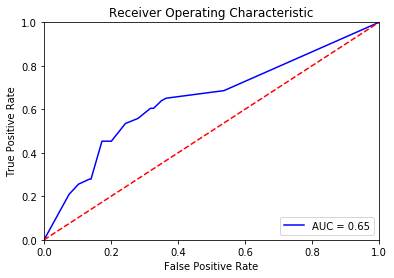

In [38]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = reg_dt_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
RandomState = np.random.seed(1234)
Test_reg_scores = []
max_depth = []
for i in range(1,20,2):    
    Test_reg_param = DecisionTreeClassifier(criterion = 'entropy', max_depth = i, random_state=RandomState )
    Test_reg_param.fit(X_train, Y_train)
    Y_predict_Test_reg = Test_reg_param.predict(X_test)
    scores = Test_reg_param.score(X_test, Y_test)
    Test_reg_scores.append(scores)
    max_depth.append(i)

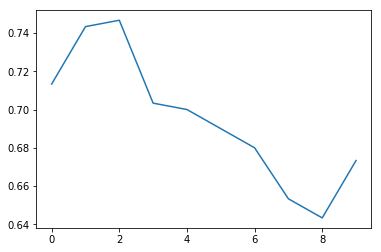

In [40]:
matplot.plot(Test_reg_scores)

In [41]:
pd.concat([pd.DataFrame(Test_reg_scores, columns = ['Scores']),
               pd.DataFrame(max_depth, columns = ['max_depth'])], axis = 1)

,Scores,max_depth
0,0.713333,1
1,0.743333,3
2,0.746667,5
3,0.703333,7
4,0.700000,9
5,0.690000,11
6,0.680000,13
7,0.653333,15
8,0.643333,17
9,0.673333,19


# Random Forest classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier

,Scores,n_estimators
0,0.733333,50
1,0.763333,75
2,0.733333,100
3,0.756667,125
4,0.746667,150
5,0.750000,175
6,0.730000,200
7,0.746667,225
8,0.753333,250
9,0.750000,275


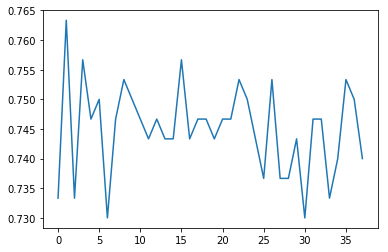

In [48]:
Test_reg_scores = []
n_estimators = []
for i in range(50,1000,25):
    Test_rfcl = RandomForestClassifier(n_estimators = i, random_state=RandomState)
    Test_rfcl = Test_rfcl.fit(X_train, Y_train)
    Test_Y_predict_rfcl = Test_rfcl.predict(X_test)
    scores = Test_rfcl.score(X_test, Y_test)
    Test_reg_scores.append(scores)
    n_estimators.append(i)
            
matplot.plot(Test_reg_scores)

pd.concat([pd.DataFrame(Test_reg_scores, columns = ['Scores']),
               pd.DataFrame(n_estimators, columns = ['n_estimators'])], axis = 1)

1.0
0.7566666666666667


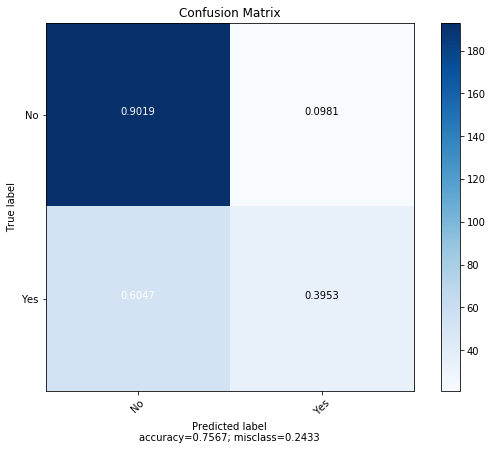

             precision    recall  f1-score   support

          0       0.79      0.90      0.84       214
          1       0.62      0.40      0.48        86

avg / total       0.74      0.76      0.74       300



,Model_Performance
Accuracy,0.756667
Recall,0.395349
Precision,0.618182
f1_Score,0.482270


In [63]:
rfcl = RandomForestClassifier(n_estimators = 75 , random_state=RandomState)
rfcl = rfcl.fit(X_train, Y_train)
Y_predict_rfcl = rfcl.predict(X_test)
print(rfcl.score(X_train , Y_train))
print(rfcl.score(X_test, Y_test))
plot_confusion_matrix(Y_test, Y_predict_rfcl, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

In [64]:
rfcl_predictions = rfcl.predict(X_test)
rfcl_predictions

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], d

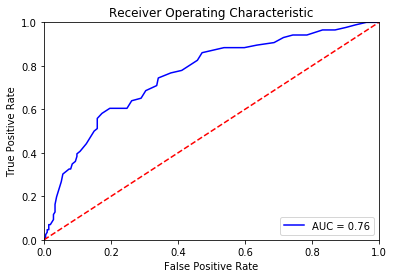

In [66]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = rfcl.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#                             Ensemble Learning - Bagging

In [149]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(base_estimator=dt_model, n_estimators=100)

#bgcl = BaggingClassifier(n_estimators=50)
bgcl = bgcl.fit(X_train, Y_train)

In [150]:
y_predict_bgcl = bgcl.predict(X_test)
y_predict_bgcl

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], d

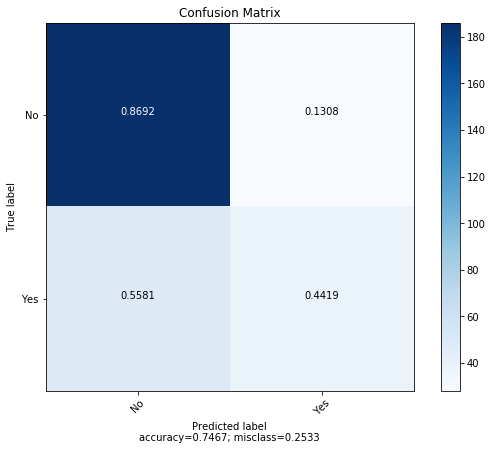

             precision    recall  f1-score   support

          0       0.79      0.87      0.83       214
          1       0.58      0.44      0.50        86

avg / total       0.73      0.75      0.74       300



,Model_Performance
Accuracy,0.746667
Recall,0.441860
Precision,0.575758
f1_Score,0.500000


In [151]:
plot_confusion_matrix(Y_test, y_predict_bgcl, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

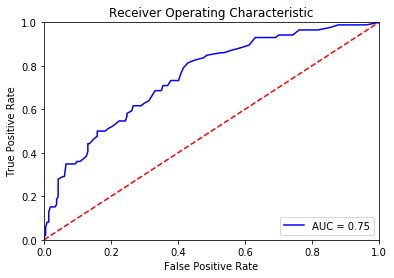

In [152]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = bgcl.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Ensemble Learning - AdaBoosting

In [153]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(base_estimator=dt_model, n_estimators=10)
#abcl = AdaBoostClassifier( n_estimators=50)
abcl = abcl.fit(X_train, Y_train)

In [154]:
y_predict_Abcl = abcl.predict(X_test)
y_predict_Abcl

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], d

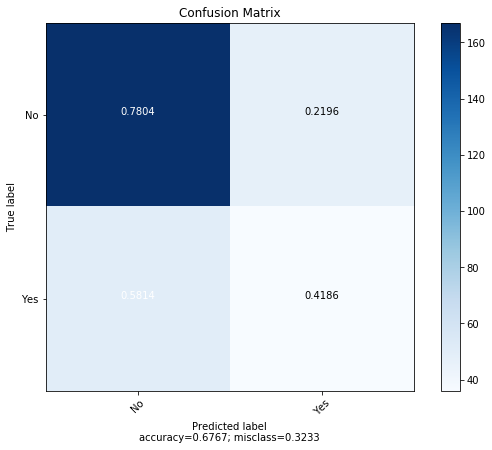

             precision    recall  f1-score   support

          0       0.77      0.78      0.77       214
          1       0.43      0.42      0.43        86

avg / total       0.67      0.68      0.67       300



,Model_Performance
Accuracy,0.676667
Recall,0.418605
Precision,0.433735
f1_Score,0.426036


In [155]:
plot_confusion_matrix(Y_test, y_predict_Abcl, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

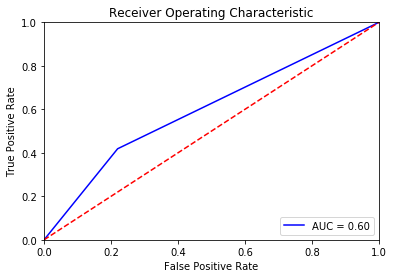

In [156]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = abcl.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#                     Ensemble Learning - GradientBoost

In [157]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate=0.1)
gbcl = gbcl.fit(X_train, Y_train)


In [158]:
y_predict_gbcl = gbcl.predict(X_test)
y_predict_gbcl

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], d

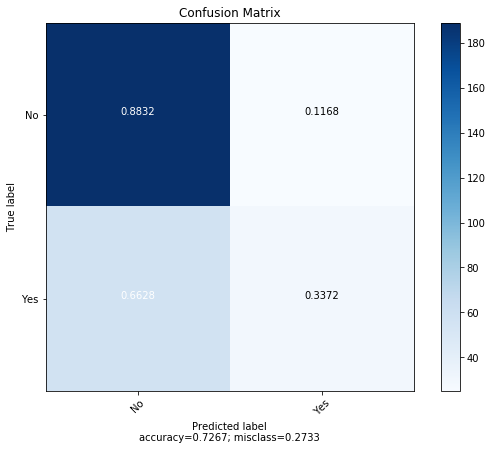

             precision    recall  f1-score   support

          0       0.77      0.88      0.82       214
          1       0.54      0.34      0.41        86

avg / total       0.70      0.73      0.70       300



,Model_Performance
Accuracy,0.726667
Recall,0.337209
Precision,0.537037
f1_Score,0.414286


In [159]:
plot_confusion_matrix(Y_test, y_predict_gbcl, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

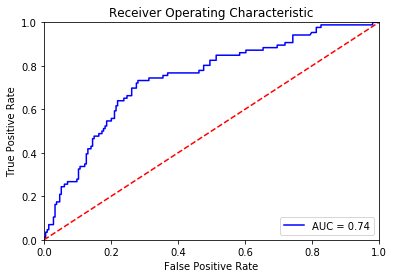

In [160]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = gbcl.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Stacking algorithms

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB

In [50]:
estimators = [('rf', RandomForestClassifier(n_estimators=75)),('logistic', LogisticRegression()), ('Naive', MultinomialNB())]
stackingclf = VotingClassifier(estimators=estimators, voting='soft')

In [51]:
stackingclf.fit(X_train,Y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...erbose=0, warm_start=False)), ('Naive', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [52]:
y_predict_stck = stackingclf.predict(X_test)

C:\Users\Sidsavi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
y_predict_stck

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], d

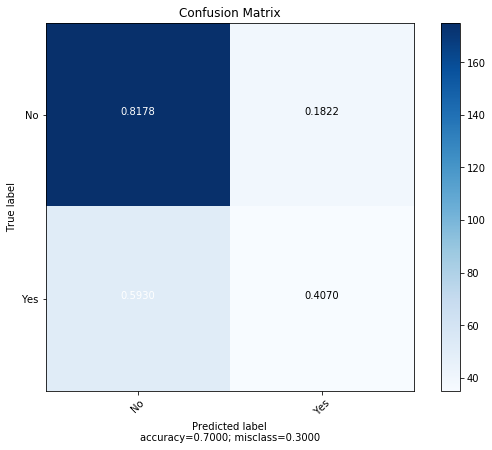

             precision    recall  f1-score   support

          0       0.77      0.82      0.80       214
          1       0.47      0.41      0.44        86

avg / total       0.69      0.70      0.69       300



,Model_Performance
Accuracy,0.700000
Recall,0.406977
Precision,0.472973
f1_Score,0.437500


In [54]:
plot_confusion_matrix(Y_test, y_predict_stck, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

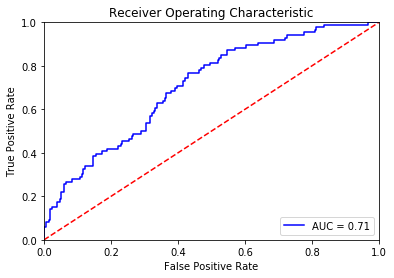

In [55]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = stackingclf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()